In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_pickle("df.pkl")

In [11]:
df.drop(columns=["LEAGUE_ID","TEAM_ID","TEAM_ABBREVIATION"],inplace=True)

In [12]:
df['SEASON_ID'] = df['SEASON_ID'].map(lambda x: int(x.split("-",1)[0]))

In [14]:
num_cols = ['PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'WIN_PCT', 'CONF_RANK', 'DIV_RANK',
       'player_of_week', 'player_of_month']

In [15]:
# standarize data season by season
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for year in  df["SEASON_ID"].unique().tolist():
    for col in num_cols:
        df.loc[df['SEASON_ID']==year, col] = scaler.fit_transform(df.loc[df['SEASON_ID']==year, col].to_numpy().reshape(-1,1))

In [16]:
train = df.loc[(df['SEASON_ID']>=2000)&(df['SEASON_ID']<=2020),:]
test = df.loc[(df['SEASON_ID']==2021),:]

In [18]:
y = train['MVP']
X = train.iloc[:,:-1]

y_test = test['MVP']
X_test = test.iloc[:,:-1]

0    11208
1       21
Name: MVP, dtype: int64


<AxesSubplot:>

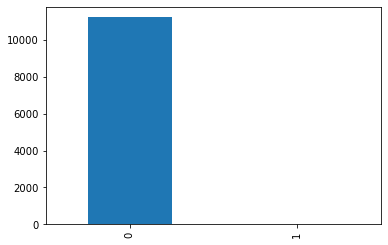

In [19]:
print(y.value_counts())
y.value_counts().plot(kind='bar')

Feature Selection

Correlation heatmap

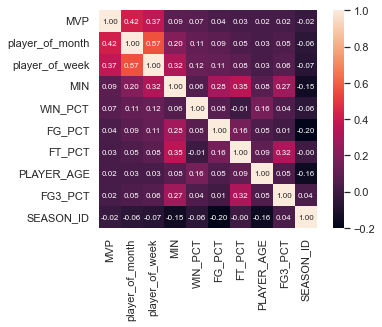

In [20]:
corrmat = df.corr()

k = 10 # show top k most correlated features
cols = corrmat.nlargest(k, 'MVP')['MVP'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [24]:
# drop correlated feautures
X_corr = X.corr()
corr_names = set()
for i in range(len(X_corr .columns)):
    for j in range(i):
        if abs(X_corr.iloc[i, j]) > 0.8:
            col = X_corr.columns[i]
            corr_names.add(col)

X.drop(columns=corr_names,inplace=True)
X_test.drop(columns=corr_names,inplace=True)


set()

In [22]:
features = ['PLAYER_AGE', 'GP_player', 'GS', 'MIN', 'FGM_player', 'FGA_player',
       'FG_PCT_player', 'FG3M_player', 'FG3A_player', 'FG3_PCT_player',
       'FTM_player', 'FTA_player', 'FT_PCT_player', 'OREB_player',
       'DREB_player', 'REB_player', 'AST_player', 'STL_player', 'BLK_player',
       'TOV_player', 'PF_player', 'PTS_player', 'WINS','player_of_week', 'player_of_month']

In [23]:
import statsmodels.api as sm
X_logit = X.drop(columns=['PLAYER_ID','SEASON_ID'])
ols = sm.Logit(y,X_logit.astype('float'))
result = ols.fit()
p_values = result.summary2().tables[1]['P>|z|']
p_values = pd.Series(p_values).sort_values(ascending = True)
p_values[p_values<=0.05]

Optimization terminated successfully.
         Current function value: 0.003281
         Iterations 23


player_of_week    0.000003
PLAYER_AGE        0.000148
MIN               0.000187
FG_PCT            0.000721
AST               0.000749
PF                0.007967
GS                0.009774
FTA               0.009836
FTM               0.022049
GP                0.024100
STL               0.026769
Name: P>|z|, dtype: float64

In [25]:
print(result.summary2())

                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.759     
Dependent Variable:  MVP               AIC:               123.6756  
Date:                2022-02-02 16:09  BIC:               306.8319  
No. Observations:    11229             Log-Likelihood:    -36.838   
Df Model:            24                LL-Null:           -152.90   
Df Residuals:        11204             LLR p-value:       5.6153e-36
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      23.0000                                        
--------------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
--------------------------------------------------------------------
PLAYER_AGE       -12.0455   3.1743 -3.7947 0.0001  -18.2670  -5.8240
GP              -236.5829 104.8899 -2.2555 0.0241 -442.1633 -31.0025
GS               284.5698 110.1386  2.5837 0.0098   68.7020 5

0.6296296296296297


Text(0.5, 1.0, 'Lasso Regression')

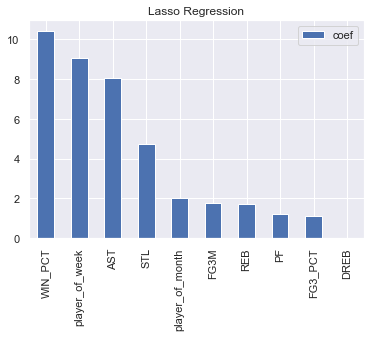

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr =LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',C=0.5)
lr.fit(X_logit,y)

print(roc_auc_score(lr.predict(X_logit),y))

# plot bar chart 
pd.DataFrame(np.abs(lr.coef_.reshape(-1,1)),index=X_logit.columns,columns=['coef']).sort_values(by=['coef'],ascending=False).head(10).plot(kind='bar')
plt.title("Lasso Regression")

Recursive selection

Text(0.5, 1.0, 'Random Forest')

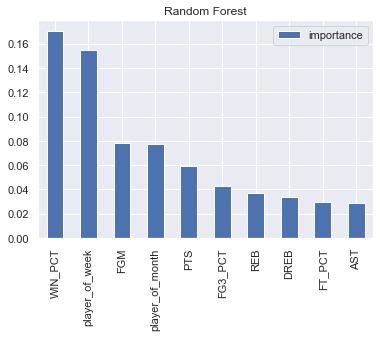

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=10,random_state=42)
rf.fit(X,y)
importance = pd.DataFrame(rf.feature_importances_,index=X.columns.tolist(),columns=['importance']).sort_values(by='importance',ascending=False)
importance.head(10).plot(kind='bar')
plt.title("Random Forest")

Modeling

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score,roc_auc_score, f1_score,plot_confusion_matrix, plot_roc_curve,plot_precision_recall_curve

model = RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=5,
criterion='entropy',max_features='auto',n_estimators=500)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [29]:
print("=====cv score=====")
print("roc_auc_avg:{:.3f}".format(np.mean(scores)))
print("roc_auc_std:{:.3f}".format(np.std(scores)))

=====cv score=====
roc_auc_avg:0.997
roc_auc_std:0.004


In [30]:
model.fit(X,y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, n_estimators=500, random_state=42)

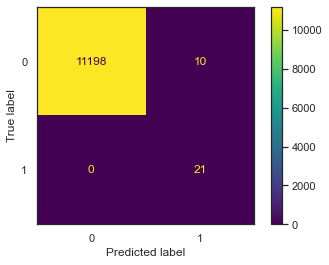

In [31]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
sns.set_style('white')
plot_confusion_matrix(model,X,y)

In [32]:
# fit to test set
result = pd.DataFrame(model.predict_proba(X_test),index = X_test.PLAYER_ID)

result.rename(columns={0:'not',1:'mvp'},inplace=True)

#result['y/n'] = model.predict(X_test)

In [33]:
mvp_candidates = result.sort_values(by='mvp',ascending=False)

In [34]:
mvp_candidates.reset_index(inplace=True)

In [35]:
mvp_candidates.drop(columns=['not'],inplace=True)

In [36]:
from nba_api.stats.static import players
# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()
print('Number of players fetched: {}'.format(len(nba_players)))

Number of players fetched: 4723


In [37]:
nba_players = pd.DataFrame(nba_players)

In [38]:
nba_players.rename(columns={"id":"PLAYER_ID"},inplace = True)

In [39]:
mvp_candidates = mvp_candidates.merge(nba_players.loc[:,['PLAYER_ID','full_name']],on='PLAYER_ID',how='left')

In [40]:
mvp_candidates.head(10)

,PLAYER_ID,mvp,full_name
0,201939,0.458621,Stephen Curry
1,1629027,0.210556,Trae Young
2,201935,0.127500,James Harden
3,1626164,0.115064,Devin Booker
4,203507,0.096838,Giannis Antetokounmpo
5,203999,0.093181,Nikola Jokic
6,1628970,0.068447,Miles Bridges
7,1628369,0.050895,Jayson Tatum
8,101108,0.048832,Chris Paul
9,201142,0.041058,Kevin Durant


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Stephen Curry'),
  Text(1, 0, 'Trae Young'),
  Text(2, 0, 'James Harden'),
  Text(3, 0, 'Devin Booker'),
  Text(4, 0, 'Giannis Antetokounmpo'),
  Text(5, 0, 'Nikola Jokic'),
  Text(6, 0, 'Miles Bridges'),
  Text(7, 0, 'Jayson Tatum'),
  Text(8, 0, 'Chris Paul'),
  Text(9, 0, 'Kevin Durant')])

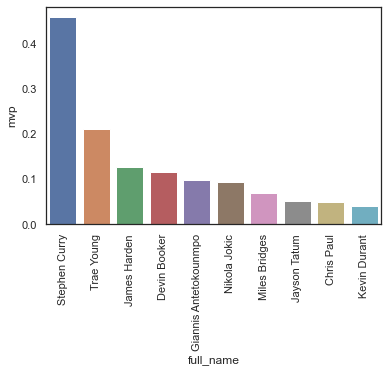

In [41]:
sns.barplot(x='full_name',y='mvp',data=mvp_candidates.head(10))
plt.xticks(rotation=90)